In [1]:
# Load seed 20 results and combine them into one csv

import pandas as pd
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

# === Step 1: Define folder and categorize CSV files ===
folder = "optimization_150000_seed20_results"
files = os.listdir(folder)

# Group files by scenario label prefix
favourable_files = [f for f in files if f.startswith("favourable_outcomes")]
unfavourable_files = [f for f in files if f.startswith("unfavourable_outcomes")]
medium_files = [f for f in files if f.startswith("medium_outcomes")]

# === Step 2: Helper function to load CSV files and combine them with labels ===
def load_and_combine(file_list, label):
    dfs = []
    for file in file_list:
        df = pd.read_csv(os.path.join(folder, file))
        # Calculate total costs for each row
        df['total costs'] = (
            df['Expected Annual Damage'] +
            df['Dike Investment Costs'] +
            df['RfR Investment Costs'] +
            df['Evacuation Costs']
        )
        # Add a scenario label column
        df['scenario'] = label
        dfs.append(df)
    # Combine all dataframes into one
    return pd.concat(dfs, ignore_index=True)

# === Step 3: Load and combine dataframes for each scenario type ===
favourable_df_20 = load_and_combine(favourable_files, 'Favourable')
unfavourable_df_20 = load_and_combine(unfavourable_files, 'Unfavourable')
medium_df_20 = load_and_combine(medium_files, 'Medium')

# Show first rows of medium scenario dataframe
medium_df_20.head()


,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,total costs,scenario
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2.534811e+09,0.000000e+00,0.0,0.0,1.767457,2.534811e+09,Medium
1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,2.866249e+08,0.000000e+00,205800000.0,0.0,0.234756,4.924249e+08,Medium
2,0,0,1,0,0,0,1,0,0,0,...,0,0,0,6.906970e+08,0.000000e+00,115300000.0,0.0,0.586774,8.059970e+08,Medium
3,0,1,0,0,0,0,1,1,0,0,...,0,0,0,6.715077e+08,0.000000e+00,146000000.0,0.0,0.567550,8.175077e+08,Medium
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,9.874335e+08,3.269490e+07,0.0,0.0,0.794456,1.020128e+09,Medium


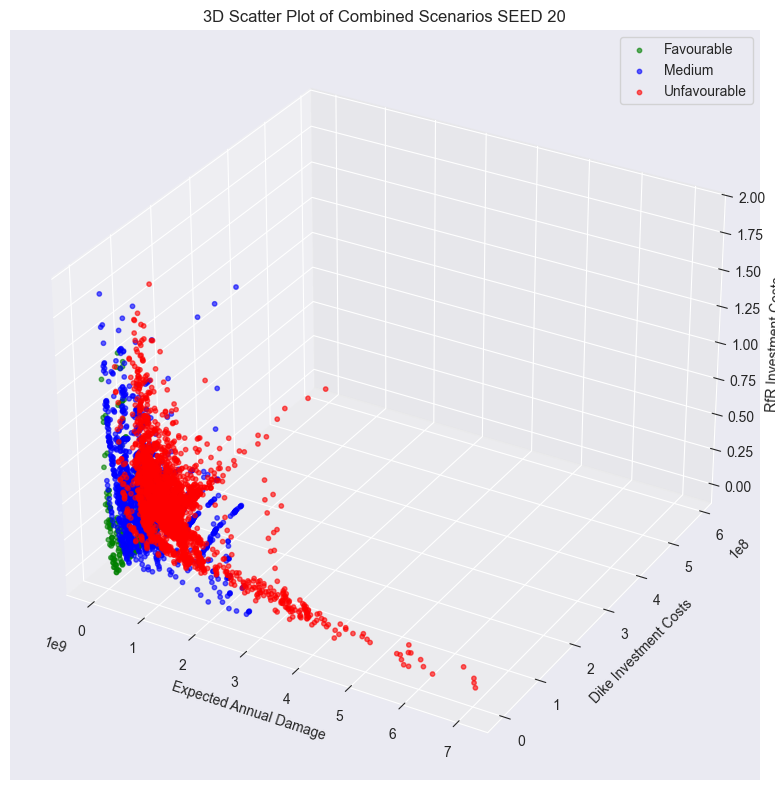

In [2]:
# Plot in 3D with each scenario group shown in a different color

# === Step 4: Plot setup ===
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot points for the Favourable scenario group in green
ax.scatter(
    favourable_df_20['Expected Annual Damage'],
    favourable_df_20['Dike Investment Costs'],
    favourable_df_20['RfR Investment Costs'],
    color='green', label='Favourable', alpha=0.6, s=10
)

# Plot points for the Medium scenario group in blue
ax.scatter(
    medium_df_20['Expected Annual Damage'],
    medium_df_20['Dike Investment Costs'],
    medium_df_20['RfR Investment Costs'],
    color='blue', label='Medium', alpha=0.6, s=10
)

# Plot points for the Unfavourable scenario group in red
ax.scatter(
    unfavourable_df_20['Expected Annual Damage'],
    unfavourable_df_20['Dike Investment Costs'],
    unfavourable_df_20['RfR Investment Costs'],
    color='red', label='Unfavourable', alpha=0.6, s=10
)

# Set axis labels
ax.set_xlabel('Expected Annual Damage')
ax.set_ylabel('Dike Investment Costs')
ax.set_zlabel('RfR Investment Costs')

# Add legend and title
ax.legend()
plt.title('3D Scatter Plot of Combined Scenarios SEED 20')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [3]:
# Define quantiles and filter the dataframe based on these quantiles
def load_thresholds(df, q_evac=0.6, q_total_cost=0.6, q_dike=0.6, q_damage=0.6, death_cap=0.025):
    # Calculate total costs as sum of relevant cost columns
    df['total costs'] = (
        df['Expected Annual Damage'] +
        df['Dike Investment Costs'] +
        df['RfR Investment Costs'] +
        df['Evacuation Costs']
    )

    # Return dataframe and a dictionary with threshold values (quantiles for costs, fixed cap for deaths)
    return df, {
        'Evacuation Costs': df['Evacuation Costs'].quantile(q_evac),
        'total costs': df['total costs'].quantile(q_total_cost),
        'Dike Investment Costs': df['Dike Investment Costs'].quantile(q_dike),
        'Expected Annual Damage': df['Expected Annual Damage'].quantile(q_damage),
        'Expected Number of Deaths': death_cap
    }

# Filter the dataframe based on thresholds dictionary
def filter_df(df, thresholds):
    return df[
        (df['Evacuation Costs'] <= thresholds['Evacuation Costs']) &
        (df['total costs'] <= thresholds['total costs']) &
        (df['Dike Investment Costs'] <= thresholds['Dike Investment Costs']) &
        (df['Expected Annual Damage'] <= thresholds['Expected Annual Damage']) &
        (df['Expected Number of Deaths'] <= thresholds['Expected Number of Deaths']) &
        (df['RfR Investment Costs'] > 0)  # Ensure RfR Investment Costs is positive
    ]

In [4]:
# These thresholds should be discussed/justified, currently set somewhat arbitrarily
# (to end up with around 5 selected policies)
fav_df, fav_thresholds = load_thresholds(
    favourable_df_20,
    q_evac=0.51,
    q_total_cost=0.51,
    q_dike=0.51,
    q_damage=0.51,
    death_cap=0.025
)

# Filter the favourable dataframe based on the calculated thresholds
fav_selected = filter_df(fav_df, fav_thresholds)

# Output number of filtered policies and preview some key columns
print(f"Filtered Favourable Policies: {len(fav_selected)} rows")
print(fav_selected[['scenario', 'total costs', 'Expected Number of Deaths']].head())


Filtered Favourable Policies: 5 rows
       scenario   total costs  Expected Number of Deaths
308  Favourable  1.439586e+08                   0.018930
309  Favourable  1.294379e+08                   0.009112
313  Favourable  1.000900e+08                   0.013036
349  Favourable  1.437296e+08                   0.019411
357  Favourable  1.583767e+08                   0.009112


In [5]:
# These thresholds should be discussed/justified, currently set somewhat arbitrarily
# (to end up with around 5 selected policies)
unfav_df, unfav_thresholds = load_thresholds(
    unfavourable_df_20,
    q_evac=0.48,
    q_total_cost=0.48,
    q_dike=0.48,
    q_damage=0.48,
    death_cap=0.025
)

# Filter the unfavourable dataframe based on the calculated thresholds
unfav_selected = filter_df(unfav_df, unfav_thresholds)

# Output number of filtered policies and preview some key columns
print(f"Filtered Unfavourable Policies: {len(unfav_selected)} rows")
print(unfav_selected[['scenario', 'total costs', 'Expected Number of Deaths']].head())


Filtered Unfavourable Policies: 5 rows
         scenario   total costs  Expected Number of Deaths
162  Unfavourable  5.579935e+08                   0.020245
634  Unfavourable  5.859752e+08                   0.017627
853  Unfavourable  3.917439e+08                   0.024517
934  Unfavourable  5.878704e+08                   0.017684
945  Unfavourable  5.015120e+08                   0.017699


In [6]:
# These thresholds should be discussed/justified, currently set somewhat arbitrarily
# (to select roughly 5 policies)
med_df, med_thresholds = load_thresholds(
    medium_df_20,
    q_evac=0.47,
    q_total_cost=0.47,
    q_dike=0.47,
    q_damage=0.47,
    death_cap=0.025
)

# Filter the medium scenario dataframe based on the calculated thresholds
med_selected = filter_df(med_df, med_thresholds)

# Print the number of filtered policies and preview key columns
print(f"Filtered Medium Policies: {len(med_selected)} rows")
print(med_selected[['scenario', 'total costs', 'Expected Number of Deaths']].head())


Filtered Medium Policies: 5 rows
     scenario   total costs  Expected Number of Deaths
198    Medium  4.509201e+08                   0.021917
933    Medium  4.694607e+08                   0.007013
957    Medium  4.716742e+08                   0.016434
995    Medium  4.929290e+08                   0.002262
1007   Medium  3.592717e+08                   0.022668


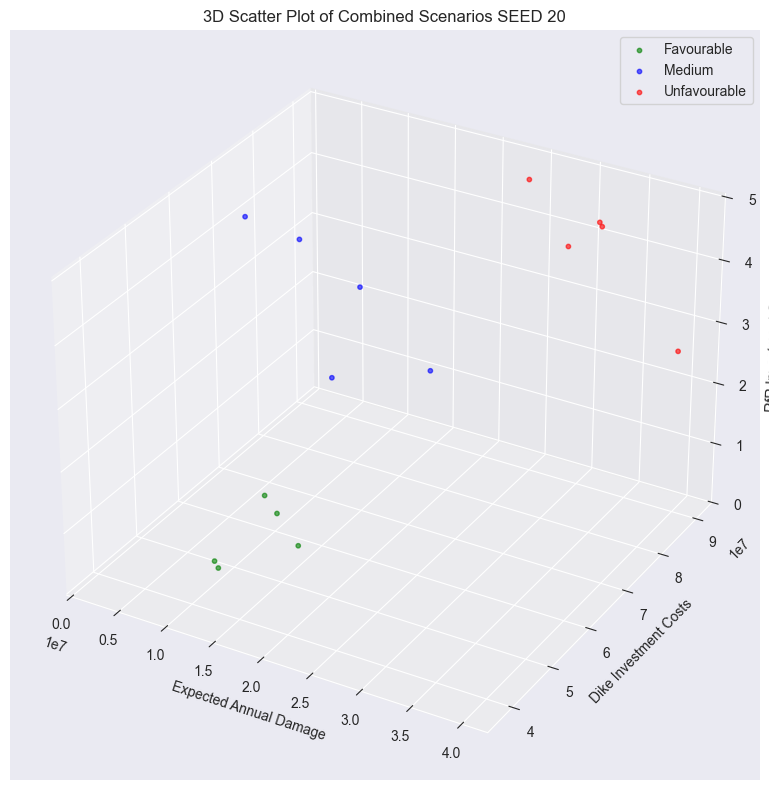

In [7]:
# Create a 3D scatter plot of the selected policies from different scenarios
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot favourable policies in green
ax.scatter(fav_selected['Expected Annual Damage'], fav_selected['Dike Investment Costs'], fav_selected['RfR Investment Costs'],
           color='green', label='Favourable', alpha=0.6, s=10)

# Plot medium policies in blue
ax.scatter(med_selected['Expected Annual Damage'], med_selected['Dike Investment Costs'], med_selected['RfR Investment Costs'],
           color='blue', label='Medium', alpha=0.6, s=10)

# Plot unfavourable policies in red
ax.scatter(unfav_selected['Expected Annual Damage'], unfav_selected['Dike Investment Costs'], unfav_selected['RfR Investment Costs'],
           color='red', label='Unfavourable', alpha=0.6, s=10)

# Set axis labels and show legend
ax.set_xlabel('Expected Annual Damage')
ax.set_ylabel('Dike Investment Costs')
ax.set_zlabel('RfR Investment Costs')
ax.legend()

plt.title('3D Scatter Plot of Combined Scenarios SEED 20')
plt.tight_layout()
plt.show()


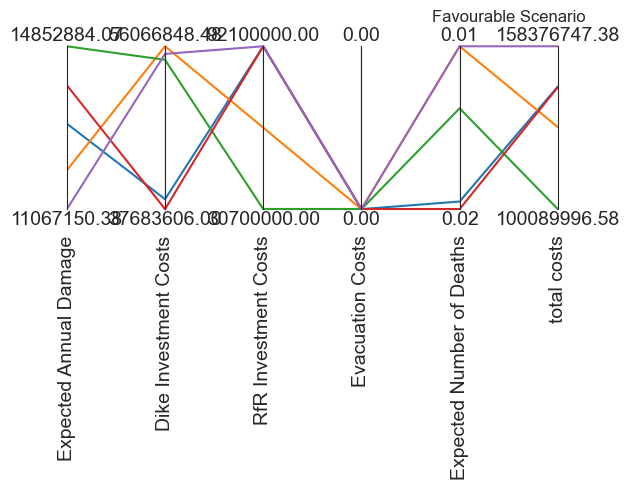

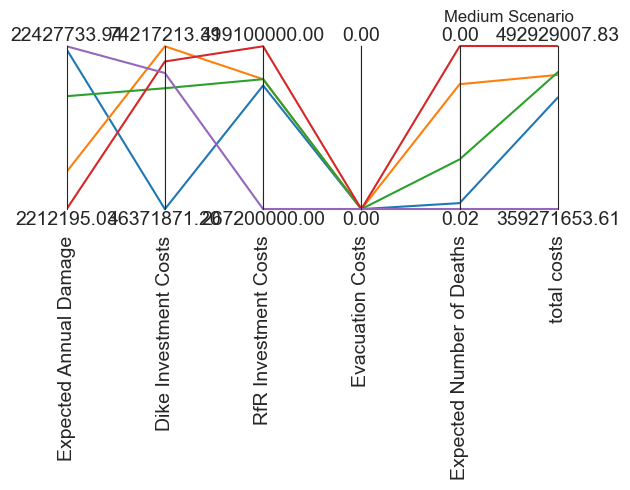

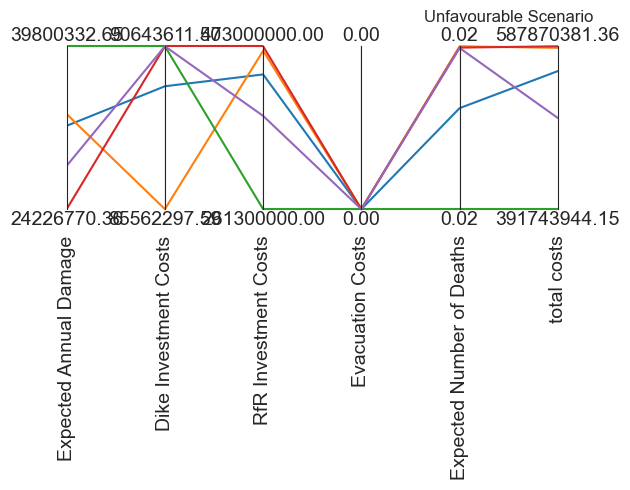

In [8]:
import matplotlib.pyplot as plt
from ema_workbench.analysis import parcoords

def plot_parallel_coords(metrics_df, title="Parallel Coordinates Plot"):
    # Select only the last 7 columns from the dataframe
    df_subset = metrics_df.iloc[:, -7:]

    # Keep only numeric columns to avoid issues with non-numeric data like 'scenario'
    df_numeric = df_subset.select_dtypes(include=['number'])

    # Generate axis limits and create the parallel coordinates plot
    limits = parcoords.get_limits(df_numeric)
    axes = parcoords.ParallelAxes(limits)
    axes.plot(df_numeric)

    # Invert the axis for 'Expected Number of Deaths' for better visualization, if it exists
    if 'Expected Number of Deaths' in df_numeric.columns:
        axes.invert_axis('Expected Number of Deaths')

    plt.title(title)
    plt.show()

# Plot parallel coordinates for each scenario group
plot_parallel_coords(fav_selected, "Favourable Scenario")
plot_parallel_coords(med_selected, "Medium Scenario")
plot_parallel_coords(unfav_selected, "Unfavourable Scenario")


In [9]:
import os
from datetime import datetime

def save_policy_csv(results_df, prefix, save=True):
    # Select all columns except the last 7 (assuming those are metrics or extra info)
    policy = results_df.iloc[:, :-7]
    # Get the current date as a string, e.g., "2025-06-14"
    current_date = datetime.now().strftime('%Y-%m-%d')

    folder_name = "policies"
    # Create the folder if it does not exist yet
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    if save:
        # Construct the filename with prefix and date
        filename = os.path.join(folder_name, f"{prefix}policy_{current_date}.csv")
        # Save the dataframe to a CSV file without the index
        policy.to_csv(filename, index=False)
        print(f"Policy saved to: {filename}")

# save_policy_csv(fav_selected, "favourable_20_")
# save_policy_csv(med_selected, "medium_20_")
# save_policy_csv(unfav_selected, "unfavourable_20_")


In [10]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    Samplers,
)
from dike_model_function import DikeNetwork  # Custom model import
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

# Initialize the dike model and planning steps with formulation version 2
dike_model, planning_steps = get_model_for_problem_formulation(2)

# Load the filtered scenario space CSV file containing scenario parameters
scenario_collection_df = pd.read_csv("scenarios/filtered_scenario_space_20.csv")

# Combine the selected policies from favourable, medium, and unfavourable groups
# Ignore the last 7 columns which may be metrics or results, keeping only policy parameters
policy_collection_20_df = pd.concat([fav_selected, med_selected, unfav_selected], ignore_index=False).iloc[:, :-7]


In [11]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
from ema_workbench import Policy, Scenario
from ema_workbench import (
    Model,
    MultiprocessingEvaluator,
    ScalarOutcome,
    IntegerParameter,
    optimize,
    Scenario,
)
from problem_formulation import get_model_for_problem_formulation

def run_policies_in_scenarios(dike_model, policy_df, scenario_df):
    # Create a timestamped output folder to store results
    output_folder = f"policy_scenario_results_{datetime.now().strftime('%Y-%m-%d_%H-%M')}"
    os.makedirs(output_folder, exist_ok=True)

    # Loop over each policy in the DataFrame
    for i, (idx, policy_row) in enumerate(policy_df.iterrows()):
        print(f"Running policy {i}...")

        # Create an EMA Workbench Policy object from the current policy row
        policy = Policy(f"policy_{i}", **policy_row.to_dict())

        # Create Scenario objects for all scenarios in scenario_df
        scenarios = []
        for j, scenario_row in scenario_df.iterrows():
            scenario = Scenario(f"scenario_{j}", **scenario_row.to_dict())
            scenarios.append(scenario)

        # Use a multiprocessing evaluator to run experiments for the given policy across all scenarios
        with MultiprocessingEvaluator(dike_model) as evaluator:
            experiments, outcomes = evaluator.perform_experiments(
                scenarios=scenarios,
                policies=[policy]
            )

        # Convert experiments (input params) to a DataFrame
        results_df = pd.DataFrame(experiments)

        # Add each outcome as a new column in the results DataFrame
        for outcome_name, outcome_values in outcomes.items():
            results_df[outcome_name] = outcome_values

        # Save results to a CSV file inside the output folder
        filename = os.path.join(output_folder, f"policy_{i}_results.csv")
        results_df.to_csv(filename, index=False)
        print(f"Saved results for policy {i} to {filename}")

# Initialize model and planning steps with formulation version 2
model, steps = get_model_for_problem_formulation(2)

# Run the policies on scenarios
run_policies_in_scenarios(model, policy_collection_20_df, scenario_collection_df)


Running policy 0...


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.61it/s]


Saved results for policy 0 to policy_scenario_results_2025-06-14_20-49\policy_0_results.csv
Running policy 1...


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.51it/s]


Saved results for policy 1 to policy_scenario_results_2025-06-14_20-49\policy_1_results.csv
Running policy 2...


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.98it/s]


Saved results for policy 2 to policy_scenario_results_2025-06-14_20-49\policy_2_results.csv
Running policy 3...


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.28it/s]


Saved results for policy 3 to policy_scenario_results_2025-06-14_20-49\policy_3_results.csv
Running policy 4...


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.73it/s]


Saved results for policy 4 to policy_scenario_results_2025-06-14_20-49\policy_4_results.csv
Running policy 5...


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.43it/s]


Saved results for policy 5 to policy_scenario_results_2025-06-14_20-49\policy_5_results.csv
Running policy 6...


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.74it/s]


Saved results for policy 6 to policy_scenario_results_2025-06-14_20-49\policy_6_results.csv
Running policy 7...


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.36it/s]


Saved results for policy 7 to policy_scenario_results_2025-06-14_20-49\policy_7_results.csv
Running policy 8...


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.55it/s]


Saved results for policy 8 to policy_scenario_results_2025-06-14_20-49\policy_8_results.csv
Running policy 9...


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.25it/s]


Saved results for policy 9 to policy_scenario_results_2025-06-14_20-49\policy_9_results.csv
Running policy 10...


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 11.05it/s]


Saved results for policy 10 to policy_scenario_results_2025-06-14_20-49\policy_10_results.csv
Running policy 11...


100%|██████████████████████████████████████████| 10/10 [00:01<00:00,  9.69it/s]


Saved results for policy 11 to policy_scenario_results_2025-06-14_20-49\policy_11_results.csv
Running policy 12...


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.35it/s]


Saved results for policy 12 to policy_scenario_results_2025-06-14_20-49\policy_12_results.csv
Running policy 13...


100%|██████████████████████████████████████████| 10/10 [00:01<00:00,  9.77it/s]


Saved results for policy 13 to policy_scenario_results_2025-06-14_20-49\policy_13_results.csv
Running policy 14...


100%|██████████████████████████████████████████| 10/10 [00:01<00:00,  7.48it/s]


Saved results for policy 14 to policy_scenario_results_2025-06-14_20-49\policy_14_results.csv


In [21]:
import os
import pandas as pd

def evaluate_minimization(df, policy_id_col, scenario_id_col, performance_cols):
    # Group the dataframe by policy id
    grouped = df.groupby(policy_id_col)
    results = []

    # For each policy group, calculate mean and std for each performance metric
    for policy, group in grouped:
        metrics = {'Policy': policy}

        for col in performance_cols:
            values = group[col]
            metrics[f'{col} Mean'] = values.mean()
            metrics[f'{col} Std'] = values.std()

        results.append(metrics)

    # Create a summary DataFrame with the aggregated metrics
    robustness_df = pd.DataFrame(results)

    # Normalize means to 0-1 range for each performance column (lower is better)
    for col in performance_cols:
        mean_col = f'{col} Mean'
        min_val = robustness_df[mean_col].min()
        max_val = robustness_df[mean_col].max()
        robustness_df[f'{mean_col} (Norm)'] = (robustness_df[mean_col] - min_val) / (max_val - min_val)

    # Compute a combined score by summing normalized means (lower = better overall performance)
    robustness_df['Combined Score'] = robustness_df[[f'{c} Mean (Norm)' for c in performance_cols]].sum(axis=1)

    return robustness_df


def find_best_policy(folder_path):
    all_dfs = []

    # Iterate over CSV files in folder ending with '_results.csv'
    for file in os.listdir(folder_path):
        if file.endswith("_results.csv"):
            policy_id = file.replace("_results.csv", "")  # Extract policy ID from filename
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)

            df['policy'] = policy_id
            df['scenario'] = df.index
            # Calculate total cost as sum of damage + investments + evacuation
            df['Total Costs'] = (
                df['Expected Annual Damage'] +
                df['Dike Investment Costs'] +
                df['RfR Investment Costs'] +
                df['Evacuation Costs']
            )
            all_dfs.append(df)

    if not all_dfs:
        raise ValueError("❌ No result CSV files found.")

    # Combine all policy scenario results into a single DataFrame
    combined_df = pd.concat(all_dfs, ignore_index=True)

    performance_columns = [
        'Expected Annual Damage',
        'Dike Investment Costs',
        'RfR Investment Costs',
        'Evacuation Costs',
        'Expected Number of Deaths',
        'Total Costs'
    ]

    # Evaluate and rank policies based on combined normalized metrics
    robustness_df = evaluate_minimization(
        combined_df,
        policy_id_col='policy',
        scenario_id_col='scenario',
        performance_cols=performance_columns
    )

    # Select the policy with the lowest combined score (best overall)
    best_policy_row = robustness_df.sort_values('Combined Score').iloc[0]
    best_policy_id = best_policy_row['Policy']

    print(f"\nBest policy (minimization only): {best_policy_id}")
    print("\nDetails:")
    print(best_policy_row)

    # Return best policy ID and the subset of combined_df matching that policy
    return best_policy_id, combined_df[combined_df['policy'] == best_policy_id]


# Usage: specify the folder containing the results CSV files
output_folder = "policy_scenario_42_results_20_2025-06-14"
best_policy, best_policy_df = find_best_policy(output_folder)



🏆 Best policy (minimization only): policy_12

🔍 Details:
Policy                                          policy_12
Expected Annual Damage Mean              507141703.150218
Expected Annual Damage Std               783451858.354356
Dike Investment Costs Mean                 90643611.50077
Dike Investment Costs Std                             0.0
RfR Investment Costs Mean                     261300000.0
RfR Investment Costs Std                              0.0
Evacuation Costs Mean                                 0.0
Evacuation Costs Std                                  0.0
Expected Number of Deaths Mean                   0.384552
Expected Number of Deaths Std                    0.557447
Total Costs Mean                         859085314.650989
Total Costs Std                          783451858.354356
Expected Annual Damage Mean (Norm)               0.032477
Dike Investment Costs Mean (Norm)                     1.0
RfR Investment Costs Mean (Norm)                 0.521366
Evacuation Cos

,discount rate 0,discount rate 1,discount rate 2,A.0_ID flood wave shape,A.1_Bmax,A.1_pfail,A.1_Brate,A.2_Bmax,A.2_pfail,A.2_Brate,...,A.5_DikeIncrease 2,scenario,policy,model,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Total Costs
30,4.5,4.5,2.5,131,147.451271,0.790717,10.0,79.050326,0.396327,1.0,...,0,0,policy_12,dikesnet,6.021726e+07,9.064361e+07,261300000.0,0.0,0.036328,4.121609e+08
31,4.5,1.5,1.5,45,42.182286,0.967730,1.0,172.834182,0.836587,10.0,...,0,1,policy_12,dikesnet,4.936949e+07,9.064361e+07,261300000.0,0.0,0.035311,4.013131e+08
32,1.5,4.5,3.5,56,261.566895,0.303766,1.0,55.231779,0.453368,1.0,...,0,2,policy_12,dikesnet,6.065868e+08,9.064361e+07,261300000.0,0.0,0.515640,9.585304e+08
33,2.5,4.5,1.5,106,200.419118,0.007219,10.0,126.852099,0.424021,1.0,...,0,3,policy_12,dikesnet,2.603002e+09,9.064361e+07,261300000.0,0.0,1.617047,2.954946e+09
34,3.5,1.5,4.5,68,92.936917,0.649394,1.5,139.980817,0.426833,1.0,...,0,4,policy_12,dikesnet,1.281327e+08,9.064361e+07,261300000.0,0.0,0.123897,4.800763e+08
35,1.5,3.5,1.5,42,340.451884,0.557560,1.0,42.055654,0.787582,10.0,...,0,5,policy_12,dikesnet,8.593570e+08,9.064361e+07,261300000.0,0.0,1.154651,1.211301e+09
36,1.5,1.5,1.5,68,77.934008,0.127479,1.0,130.265409,0.207233,1.5,...,0,6,policy_12,dikesnet,1.378593e+08,9.064361e+07,261300000.0,0.0,0.055834,4.898029e+08
37,1.5,2.5,1.5,70,180.673553,0.325521,1.0,144.987938,0.109115,1.0,...,0,7,policy_12,dikesnet,4.316765e+07,9.064361e+07,261300000.0,0.0,0.027314,3.951113e+08
38,1.5,1.5,1.5,96,227.709499,0.318561,10.0,146.650007,0.031419,1.5,...,0,8,policy_12,dikesnet,3.044590e+08,9.064361e+07,261300000.0,0.0,0.120494,6.564026e+08
39,1.5,2.5,2.5,58,150.656113,0.150643,1.5,197.365197,0.021697,10.0,...,0,9,policy_12,dikesnet,2.792654e+08,9.064361e+07,261300000.0,0.0,0.159008,6.312090e+08


# Runnen met andere scenarios (Test)
Dit moeten we eigenlijk pas doen als alle tresholds goed zijn vastgesteld, maar wilde het alvast proberen. Idee is om de beste policy/policies dan weer te runnen tegen een grotere groep scenarios

In [ ]:
# Inladen van alle scenarios en outcomes die we hebben. Deze heb ik opnieuw gerund en gepusht dus chech even in de results folder of deze nieuwe scenario space er in staat!

import pandas as pd

# Define the folder path and file names
folder_name = "results"
date = "2025-06-11"  # Replace with the exact date if needed

# Load the experiments DataFrame
experiments = pd.read_csv(f"{folder_name}/scenario_space_100000_experiments_2025-06-11_21-41.csv")


In [ ]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
from ema_workbench import Policy, Scenario

def run_policies_in_scenarios(dike_model, policy_df, scenario_df):
    output_folder = f"policy_scenario_results_{datetime.now().strftime('%Y-%m-%d_%H-%M')}"
    os.makedirs(output_folder, exist_ok=True)

    for i, (idx, policy_row) in enumerate(policy_df.iterrows()):
        print(f"Running policy {i}...")

        # Create Policy object
        policy = Policy(f"policy_{i}", **policy_row.to_dict())

        # Create list of Scenario objects from scenario_df
        scenarios = []
        for j, scenario_row in scenario_df.iterrows():
            scenario = Scenario(f"scenario_{j}", **scenario_row.to_dict())
            scenarios.append(scenario)

        # Run experiments
        with MultiprocessingEvaluator(dike_model) as evaluator:
            experiments, outcomes = evaluator.perform_experiments(
                scenarios=scenarios,
                policies=[policy]
            )

        # Combine experiments and outcomes
        results_df = pd.DataFrame(experiments)
        for outcome_name, outcome_values in outcomes.items():
            results_df[outcome_name] = outcome_values

        # Save per-policy results
        filename = os.path.join(output_folder, f"policy_{i}_results.csv")
        results_df.to_csv(filename, index=False)
        print(f"Saved results for policy {i} to {filename}")

    run_policies_in_scenarios(dike_model, policy_collection_20_df, scenario_collection_df)

